In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore


In [2]:
#load data
atlas_path = "/home/gabridele/Desktop/irbio_folder/spreading_dynamics_clinical/derivatives/templates/Schaefer2018_400Parcels_Tian_Subcortex_S4_2mm_2009c_NLinAsymm.nii.gz"
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower") 

In [6]:
%cd ~/Desktop

/home/gabridele/Desktop


In [8]:
# Load data
vols = pd.read_csv("irbio_folder/spreading_dynamics_clinical/derivatives/sub-10227/func/mod_sub-10227_mean_cope_resampled_ts_1vol.csv", sep='\t')
vols.index.name = 'Parcels'
vols.index += 1

vols = vols.reindex(sorted(vols.columns), axis=1)

In [36]:
"""zscored_vols = vols.apply(zscore, axis=1)

roi_iqr = zscored_vols.apply(lambda x: x.quantile(0.75) - x.quantile(0.25), axis=1)
print(roi_iqr)"""

Parcels
1      1.084825
2      1.184077
3      1.452108
4      1.568265
5      1.185797
         ...   
450    1.342307
451    1.317956
452    1.475362
453    1.052464
454    1.347649
Length: 454, dtype: float64


In [10]:
stats_data = np.zeros_like(atlas_data)

for roi_index in range(1, len(vols) + 1):
    roi_indices = np.where(atlas_data == roi_index)
    stats_data[roi_indices] = vols[roi_index - 1]

stats_img = nib.Nifti1Image(stats_data, atlas_img.affine, header=atlas_img.header)
nib.save(stats_img, 'tryyyyyyyyyy.nii.gz')

KeyError: 0

In [24]:
!pwd

/home/gabridele/Desktop/irbio_folder


Plotting for group: CTRL


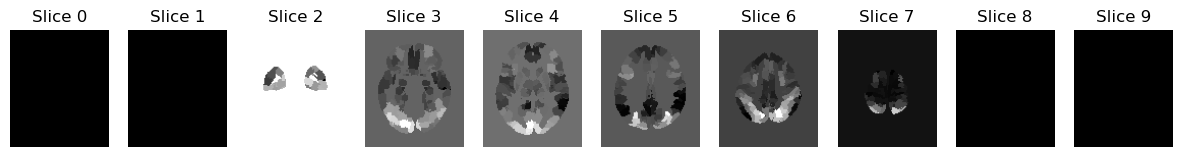

Plotting for group: SCZ


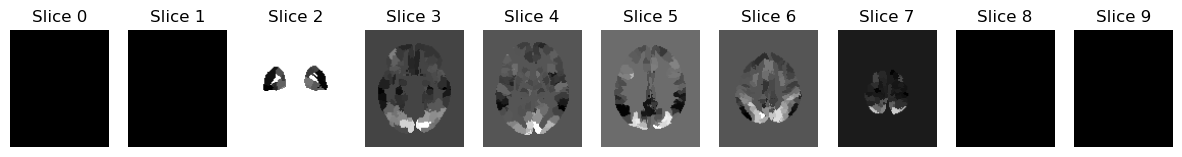

Plotting for group: BPLR


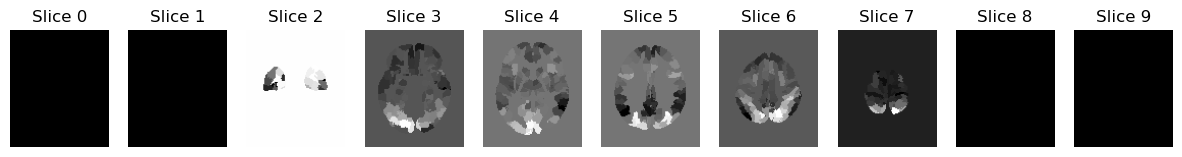

Plotting for group: ADHD


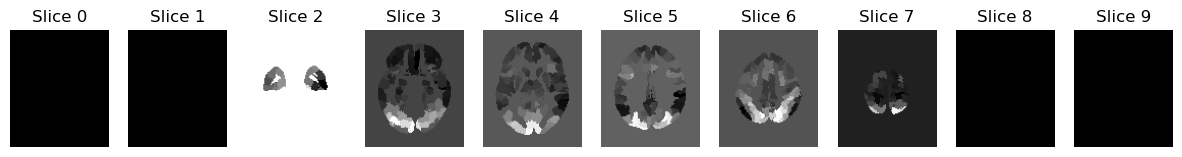

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy.stats import zscore
import nibabel as nib

# Define the base directory for your data files
base_dir = 'spreading_dynamics_clinical/preproc_dl/'

# Define groups and corresponding patterns
groups = {
    'CTRL': 'sub-1*/scap.feat/sub-1*_mean_cope_resampled_ts_1vol.npy',
    'SCZ': 'sub-5*/scap.feat/sub-5*_mean_cope_resampled_ts_1vol.npy',
    'BPLR': 'sub-6*/scap.feat/sub-6*_mean_cope_resampled_ts_1vol.npy',
    'ADHD': 'sub-7*/scap.feat/sub-7*_mean_cope_resampled_ts_1vol.npy'
}

target_shape = (454, 1)

"""def pad_matrix(matrix, target_shape):
    Pad matrix to the target shape with zeros
    current_shape = matrix.shape
    pad_height = target_shape[0] - current_shape[0]
    pad_width = target_shape[1] - current_shape[1]
    
    # Calculate padding widths
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    
    # Pad the matrix
    padded_matrix = np.pad(matrix, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')
    return padded_matrix
"""

def load_data(files, target_shape):
    data_list = []
    for file in files:
        data = np.load(file)
        #padded_data = pad_matrix(data, target_shape)
        data_list.append(data)
    return data_list

def compute_mean(subjects_data):
    if not subjects_data:
        return None
    
    correlation_matrices = np.array(subjects_data)
    mean_matrix = np.mean(correlation_matrices, axis=0)
    return mean_matrix

mean_matrices = {}
for group_name, pattern in groups.items():
    file_pattern = os.path.join(base_dir, pattern)
    files = glob.glob(file_pattern, recursive=True)
    if not files:
        print(f"No files found for pattern: {file_pattern}")
        continue
    subjects_data = load_data(files, target_shape)
    mean = compute_mean(subjects_data)
    if mean is None:
        print(f"No valid matrices for group: {group_name}")
        continue
    mean_matrices[group_name] = mean

# Load the atlas data
atlas_path = "spreading_dynamics_clinical/derivatives/templates/Schaefer2018_400Parcels_Tian_Subcortex_S4_2mm_2009c_NLinAsymm.nii.gz"
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Function to map the mean activation values to the atlas
def map_activations_to_atlas(mean_activations, atlas_data):
    mapped_data = np.zeros_like(atlas_data)
    for roi_index in range(1, len(mean_activations) + 1):
        roi_indices = np.where(atlas_data == roi_index)
        mapped_data[roi_indices] = mean_activations[roi_index - 1]
    return mapped_data

# Function to display image slices
def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(15, 5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        axes[i].set_title(f'Slice {i}')
        axes[i].axis('off')
    plt.show()

# Function to plot slices of the mapped data
def plot_mapped_slices(mapped_data, num_slices=10):
    """ Function to plot slices of the mapped data """
    slices = [mapped_data[:, :, i] for i in np.linspace(0, mapped_data.shape[2] - 1, num_slices).astype(int)]
    show_slices(slices)

# Process and plot each group's mean data
for group_name, emp_mean_activations in mean_matrices.items():
    zscored = zscore(emp_mean_activations)
    np.save(f'{group_name}_emp_mean_activations.npy', zscored)
    mapped_data = map_activations_to_atlas(zscored, atlas_data)
    print(f'Plotting for group: {group_name}')
    plot_mapped_slices(mapped_data)

    # Save the mapped data to a NIfTI file
    mapped_img = nib.Nifti1Image(mapped_data, atlas_img.affine, header=atlas_img.header)
    nib.save(mapped_img, f'{group_name}_empirical_values_mapped.nii.gz')


Plotting for group: CTRL


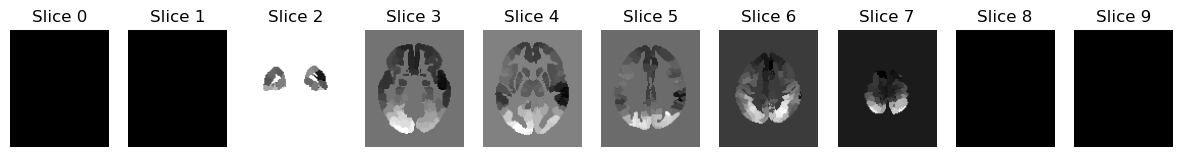

Plotting for group: SCZ


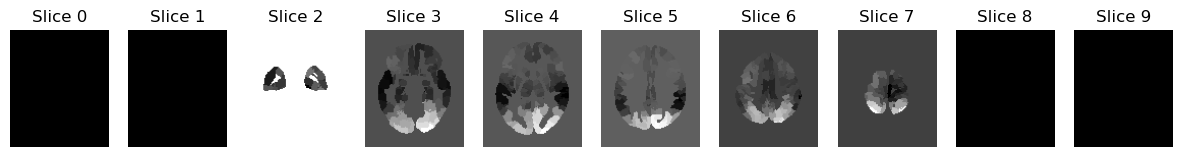

Plotting for group: BPLR


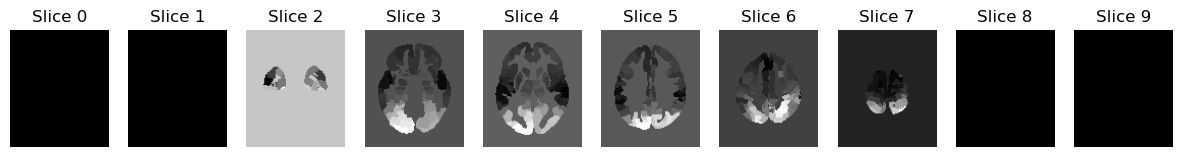

Plotting for group: ADHD


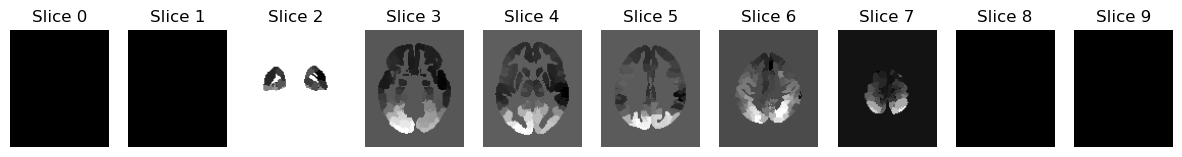

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import nibabel as nib

# Define the base directory for your data files
base_dir = 'spreading_dynamics_clinical/derivatives/output_AFM_40'

# Define groups and corresponding patterns
groups = {
    'CTRL': 'taskPredMatrix_sub-1*_40.npy',
    'SCZ': 'taskPredMatrix_sub-5*_40.npy',
    'BPLR': 'taskPredMatrix_sub-6*_40.npy',
    'ADHD': 'taskPredMatrix_sub-7*_40.npy'
}
target_shape = (454, 1, 1)


def pad_matrix(matrix, target_shape):
    """Pad matrix to the target shape with zeros."""
    current_shape = matrix.shape
    pad_height = max(target_shape[0] - current_shape[0], 0)
    pad_width = max(target_shape[1] - current_shape[1], 0)
    pad_depth = max(target_shape[2] - current_shape[2], 0)
    
    # Calculate padding widths
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    pad_front = pad_depth // 2
    pad_back = pad_depth - pad_front
    
    # Pad the matrix
    padded_matrix = np.pad(matrix, ((pad_top, pad_bottom), (pad_left, pad_right), (pad_front, pad_back)), mode='constant')
    return padded_matrix

def load_data(files, target_shape):
    data_list = []
    for file in files:
        data = np.load(file)
        if data.ndim == 1:
            data = data[:, np.newaxis, np.newaxis]  # Convert to (n, 1, 1) shape
        padded_data = pad_matrix(data, target_shape)
        data_list.append(padded_data)
    return data_list

def compute_mean(subjects_data):
    if not subjects_data:
        return None
    
    correlation_matrices = np.array(subjects_data)
    mean_matrix = np.mean(correlation_matrices, axis=0)
    return mean_matrix

mean_matrices = {}
for group_name, pattern in groups.items():
    file_pattern = os.path.join(base_dir, pattern)
    files = glob.glob(file_pattern, recursive=True)
    if not files:
        print(f"No files found for pattern: {file_pattern}")
        continue
    subjects_data = load_data(files, target_shape)
    mean = compute_mean(subjects_data)
    if mean is None:
        print(f"No valid matrices for group: {group_name}")
        continue
    mean_matrices[group_name] = mean

# Load the atlas data
atlas_path = "spreading_dynamics_clinical/derivatives/templates/Schaefer2018_400Parcels_Tian_Subcortex_S4_2mm_2009c_NLinAsymm.nii.gz"
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Function to map the mean activation values to the atlas
def map_activations_to_atlas(mean_activations, atlas_data):
    mapped_data = np.zeros_like(atlas_data)
    for roi_index in range(1, len(mean_activations) + 1):
        roi_indices = np.where(atlas_data == roi_index)
        mapped_data[roi_indices] = mean_activations[roi_index - 1]
    return mapped_data

# Function to display image slices
def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(15, 5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        axes[i].set_title(f'Slice {i}')
        axes[i].axis('off')
    plt.show()

# Function to plot slices of the mapped data
def plot_mapped_slices(mapped_data, num_slices=10):
    """ Function to plot slices of the mapped data """
    slices = [mapped_data[:, :, i] for i in np.linspace(0, mapped_data.shape[2] - 1, num_slices).astype(int)]
    show_slices(slices)

# Process and plot each group's mean data
for group_name, pred_mean_activations in mean_matrices.items():
    zscored = zscore(pred_mean_activations)
    np.save(f'{group_name}_pred_mean_activations.npy', zscored)
    mapped_data = map_activations_to_atlas(zscored, atlas_data)
    print(f'Plotting for group: {group_name}')
    plot_mapped_slices(mapped_data)

    # Save the mapped data to a NIfTI file
    mapped_img = nib.Nifti1Image(mapped_data, atlas_img.affine, header=atlas_img.header)
    nib.save(mapped_img, f'{group_name}_predicted_values_mapped.nii.gz')


In [66]:
from scipy.stats import spearmanr
BPLR_pred = np.load('ADHD_pred_mean_activations.npy')
BPLR_emp = np.load('ADHD_emp_mean_activations.npy')

vector_pred = BPLR_pred.flatten()
vector_emp = BPLR_emp.flatten()

correlation, p_value = spearmanr(vector_pred, vector_emp)
print(correlation, p_value)

0.6660543529172638 1.5918738937458481e-59


In [67]:
def scatter_plot_func(p_array, e_array, spearman_corr, spearman_p_val, sub_id=None, save_dir=None, n_seeds=None):
    
    # make sure value is of float type
    spearman_corr = float(spearman_corr)
    spearman_p_val = float(spearman_p_val)
    
    pred_values = p_array
    actual_values = e_array

    plt.figure()
    plt.scatter(range(len(pred_values)), pred_values, color='lightblue', label='Predicted Activation')
    plt.scatter(range(len(actual_values)), actual_values, color='lightcoral', label='Empirical Activation')

    plt.title(f'Predicted vs Empirical Activation for {sub_id} - {n_seeds}-seeds association matrix based' if sub_id else f'Predicted vs Empirical Activation - {n_seeds}-seeds association matrix based')
    plt.xlabel('Region')
    plt.ylabel('Activation')

    plt.legend(
        loc='upper left',  # position inside the plot
        bbox_to_anchor=(1.05, 1),  # move legend outside the plot
        borderaxespad=0.,
        title=f"Spearman's $\\rho$: {spearman_corr:.3f} (p={spearman_p_val:.2g})"
    )
    if save_dir and sub_id:
        save_path = f"{save_dir}/scatter_plot_{sub_id}.png"
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()
    
    return

Plot saved to ./scatter_plot_ADHD.png


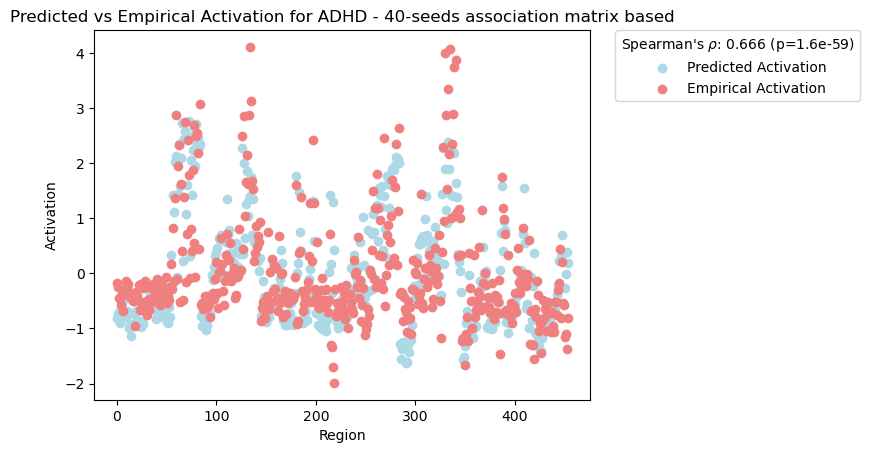

In [68]:
save_dir='.'
n_seeds=40
sub_id='ADHD'

scatter_plot_func(BPLR_pred, BPLR_emp, correlation, p_value, sub_id, save_dir, n_seeds)
